In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# halo catalog
import h5py
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
halo_fname = 'abacus/RShalos_allprops.hdf5'
halo_path = os.path.join(project_path,halo_fname)
f = h5py.File(halo_path,'r')
halos = f['halos']
print(halos.dtype)
mass = halos['m'] # which mass is this?

[('id', '<i8'), ('parent_id', '<i8'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('corevel', '<f4', (3,)), ('bulkvel', '<f4', (3,)), ('m', '<f4'), ('m_SO', '<f4'), ('r', '<f4'), ('child_r', '<f4'), ('vmax_r', '<f4'), ('mgrav', '<f4'), ('vmax', '<f4'), ('rvmax', '<f4'), ('rs', '<f4'), ('klypin_rs', '<f4'), ('vrms', '<f4'), ('J', '<f4', (3,)), ('energy', '<f4'), ('spin', '<f4'), ('alt_m', '<f4', (4,)), ('alt_m_SO', '<f4', (4,)), ('Xoff', '<f4'), ('Voff', '<f4'), ('b_to_a', '<f4'), ('c_to_a', '<f4'), ('A', '<f4', (3,)), ('b_to_a2', '<f4'), ('c_to_a2', '<f4'), ('A2', '<f4', (3,)), ('bullock_spin', '<f4'), ('kin_to_pot', '<f4'), ('m_pe_b', '<f4'), ('m_pe_d', '<f4'), ('halfmass_radius', '<f4'), ('num_p', '<i8'), ('num_child_particles', '<i8'), ('p_start', '<i8'), ('desc', '<i8'), ('flags', '<i8'), ('n_core', '<i8'), ('subsamp_start', '<i8'), ('subsamp_len', '<i8'), ('min_pos_err', '<f4'), ('min_vel_err', '<f4'), ('min_bulkvel_err', '<f4'), ('N', '<i4'), ('alt_N', '<i4', (4,)), ('N_SO', '<i4

In [3]:
#mass = halos['alt_m_SO'] # how to get M500c?

In [4]:
print(len(mass))

9859105


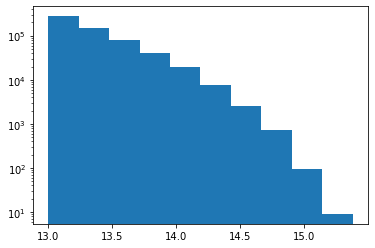

In [5]:
sel = mass > 1e+13
plt.hist(np.log10(mass[sel]))
plt.yscale('log')
lnM = np.log(mass[sel])
nh = len(lnM)

In [6]:
print(nh)

584257


In [7]:
lnlam0 = 4.25
Alam = 0.939
Blam = 0.32
Mpiv = 5e+14
z = 0.3

lnlam_mean = lnlam0 + Alam * (lnM - np.log(Mpiv)) + Blam * np.log((1+z)/1.45)

lnASZ = np.log(5.24)
BSZ = 1.534
CSZ = 0.465

# 0.161
lnSZ_mean = lnASZ + BSZ * (lnM - np.log(4.3e+14)) + CSZ * np.log(1) # TODO

import copy
lnMwl_mean = copy.deepcopy(lnM)

1.7227824
294.91986


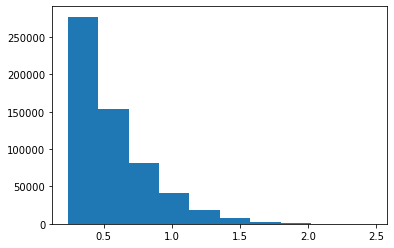

In [8]:
plt.hist(lnlam_mean/np.log(10))
print(min(np.exp(lnlam_mean)))
print(max(np.exp(lnlam_mean)))

0.016413674
73.10144


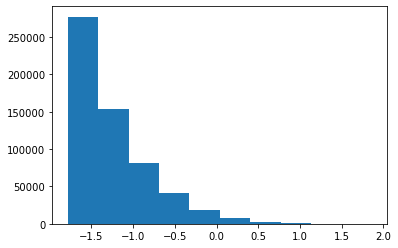

In [9]:
plt.hist(lnSZ_mean/np.log(10))
print(min(np.exp(lnSZ_mean)))
print(max(np.exp(lnSZ_mean)))

In [10]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [11]:
def draw_observables(r, scatter_wl=0.2, scatter_lam=0.3, scatter_SZ=0.151, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4)):
    
    mv = multivariate_normal([0, 0], [[1, r], [r, 1]])
    rv = mv.rvs(size=nh)
    x = rv[:,0]
    y = rv[:,1]
    
    gauss = norm(0, 1)
    z = gauss.rvs(size=nh)
    # from scipy.stats import pearsonr, spearmanr
    # print('pearson', pearsonr(x,y))
    # print('spearman (rank)', spearmanr(x,y))


    lnlam = lnlam_mean + scatter_lam * x
    lnMwl = lnMwl_mean + scatter_wl * y
    lnSZ = lnSZ_mean + scatter_SZ * z
    
    # plt.figure(figsize=(21,7))
    # plt.subplot(131)
   # plt.scatter(lnlam, lnMwl)
    # plt.subplot(132)
    # plt.scatter(lnMwl, lnSZ)
    # plt.subplot(133)
    # plt.scatter(lnSZ, lnlam)
    
    det = (lnSZ > lnSZ_cut)&(lnlam > lnlam_min)&(lnlam < lnlam_max) #
    nodet = (lnSZ < lnSZ_cut)&(lnlam > lnlam_min)&(lnlam < lnlam_max) # 

    lnMwl_det = np.mean(lnMwl[det])
    lnMwl_nodet = np.mean(lnMwl[nodet])
    det_frac = len(lnMwl[det])/(len(lnMwl[det])+len(lnMwl[nodet]))
    return lnMwl_det, lnMwl_nodet, det_frac

    """
   data = np.vstack([lnlam_mid, lnMwl_det/lnMwl_nodet]).transpose()
   
    np.savetxt(f'ratio_r{r}.dat', data)
    data = np.vstack([lnlam_mid, det_frac]).transpose()
    np.savetxt(f'frac_r{r}.dat', data)
    """
    
for r in [0, 0.5, 0.99]:
    print(draw_observables(r))
    
'''   
plt.figure(figsize=(10,8))
for r in [0, 0.5, 0.99]:
    lam, ratio = np.loadtxt(f'ratio_r{r}.dat', unpack=True)
    plt.plot(np.exp(lam), ratio, label=f'r={r}')
    plt.xscale('log')
plt.xlabel(r'$\lambda$ bin')
plt.ylabel(r'$\rm M_{wl}(det)/M_{wl}(non-det)$')
plt.legend() 


plt.figure(figsize=(10,8))
for r in [0, 0.5, 0.99]:
    lam, ratio = np.loadtxt(f'frac_r{r}.dat', unpack=True)
    plt.plot(np.exp(lam), ratio, label=f'r={r}')
    plt.xscale('log')
plt.xlabel(r'$\lambda$ bin')
plt.ylabel(r'detection fraction')
plt.legend() 
''' 

(33.82117584943593, 32.73177936565653, 0.10240890933301053)
(33.81641922409569, 32.792762510780726, 0.10211563889890612)
(33.832173101802134, 32.861408355333836, 0.10068924183398262)


"   \nplt.figure(figsize=(10,8))\nfor r in [0, 0.5, 0.99]:\n    lam, ratio = np.loadtxt(f'ratio_r{r}.dat', unpack=True)\n    plt.plot(np.exp(lam), ratio, label=f'r={r}')\n    plt.xscale('log')\nplt.xlabel(r'$\\lambda$ bin')\nplt.ylabel(r'$\rm M_{wl}(det)/M_{wl}(non-det)$')\nplt.legend() \n\n\nplt.figure(figsize=(10,8))\nfor r in [0, 0.5, 0.99]:\n    lam, ratio = np.loadtxt(f'frac_r{r}.dat', unpack=True)\n    plt.plot(np.exp(lam), ratio, label=f'r={r}')\n    plt.xscale('log')\nplt.xlabel(r'$\\lambda$ bin')\nplt.ylabel(r'detection fraction')\nplt.legend() \n"

#### Test 1: no SZ scatter, no WL scatter, no lambda selection

In [12]:
lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=0, scatter_wl=0, scatter_lam=0, scatter_SZ=0, 
                     lnlam_min=-1e5, lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
print('frac difference', lnMwl_det - lnMwl_nodet)

frac difference 3.1274510424320603


#### Test 2: no SZ scatter, no WL scatter, adding lambda threshold

In [13]:
lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=0, scatter_wl=0, scatter_lam=0, scatter_SZ=0, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
print('frac difference', lnMwl_det - lnMwl_nodet)

frac difference 0.9498671508349616


#### Test 3: adding WL scatter, no SZ scatter, adding lambda threshold

Text(0, 0.5, 'frac diff in $\\rm M_{wl}$')

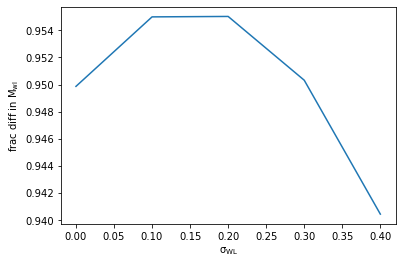

In [14]:
scatter_wl_list = np.linspace(0,0.4, 5)
diff_list = np.zeros(len(scatter_wl_list))
for i, scatter_wl in enumerate(scatter_wl_list):
    lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=0, scatter_wl=scatter_wl, scatter_lam=0, scatter_SZ=0, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
    diff_list[i] = lnMwl_det - lnMwl_nodet
plt.plot(scatter_wl_list, diff_list)
plt.xlabel(r'$\rm \sigma_{WL}$')
plt.ylabel(r'frac diff in $\rm M_{wl}$')

#### Test 4: adding SZ scatter, no WL scatter, adding lambda threshold

Text(0, 0.5, 'frac diff in $\\rm M_{wl}$')

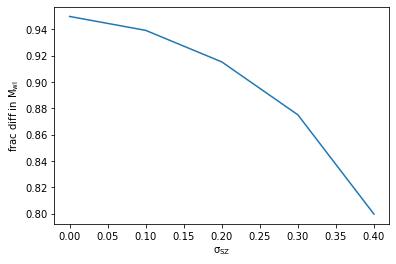

In [15]:
scatter_SZ_list = np.linspace(0,0.4, 5)
diff_list = np.zeros(len(scatter_SZ_list))
for i, scatter_SZ in enumerate(scatter_SZ_list):
    lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=0, scatter_wl=0, scatter_lam=0, scatter_SZ=scatter_SZ, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
    diff_list[i] = lnMwl_det - lnMwl_nodet
plt.plot(scatter_wl_list, diff_list)
plt.xlabel(r'$\rm \sigma_{SZ}$')
plt.ylabel(r'frac diff in $\rm M_{wl}$')

#### Test 5: adding lambda scatter, no SZ scatter, no WL scatter, adding lambda threshold

Text(0, 0.5, 'frac diff in $\\rm M_{wl}$')

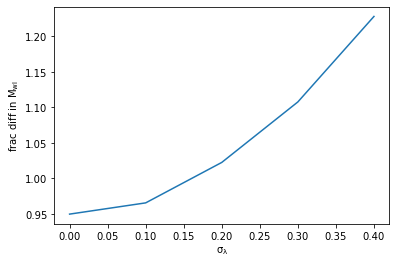

In [16]:
scatter_lam_list = np.linspace(0,0.4, 5)
diff_list = np.zeros(len(scatter_lam_list))
for i, scatter_lam in enumerate(scatter_lam_list):
    lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=0, scatter_wl=0, scatter_lam=scatter_lam, scatter_SZ=0, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
    diff_list[i] = lnMwl_det - lnMwl_nodet
plt.plot(scatter_wl_list, diff_list)
plt.xlabel(r'$\rm \sigma_{\lambda}$')
plt.ylabel(r'frac diff in $\rm M_{wl}$')

#### Test 6: adding lambda scatter, "varying" SZ scatter, adding WL scatter, adding lambda threshold

Text(0.5, 1.0, '$\\sigma_{wl}=0.1, \\sigma_{\\lambda}=0.3$')

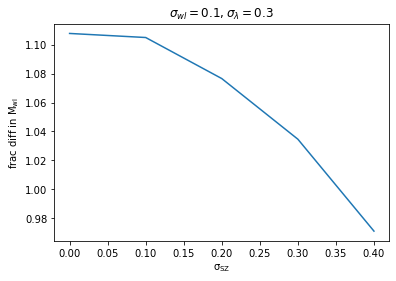

In [17]:
scatter_SZ_list = np.linspace(0,0.4, 5)
diff_list = np.zeros(len(scatter_SZ_list))
for i, scatter_SZ in enumerate(scatter_SZ_list):
    lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=0, scatter_wl=0.1, scatter_lam=0.3, scatter_SZ=scatter_SZ, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
    diff_list[i] = lnMwl_det - lnMwl_nodet
plt.plot(scatter_wl_list, diff_list)
plt.xlabel(r'$\rm \sigma_{SZ}$')
plt.ylabel(r'frac diff in $\rm M_{wl}$')
plt.title(r'$\sigma_{wl}=0.1, \sigma_{\lambda}=0.3$')

#### Test 7: fixing lambda scatter, fixing SZ scatter, fixing WL scatter, varying correlation, adding lambda threshold

Text(0.5, 1.0, '$\\rm \\sigma_{wl}=0.1, \\sigma_{\\lambda}=0.3,  \\sigma_{SZ}=0.15$')

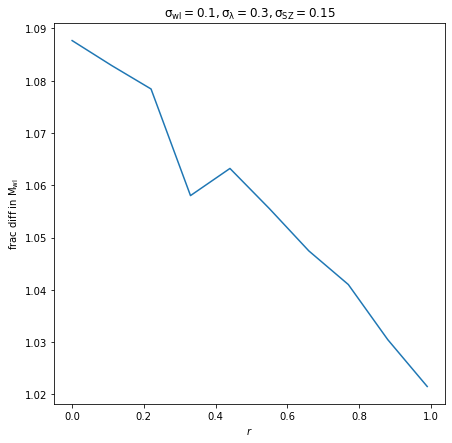

In [18]:
r_list = np.linspace(0, 0.99, 10)
diff_list = np.zeros(len(r_list))
for i, r in enumerate(r_list):
    lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=r, scatter_wl=0.1, scatter_lam=0.3, scatter_SZ=0.15, 
                     lnlam_min=np.log(20), lnlam_max=np.log(1000), lnSZ_cut=np.log(4))
    diff_list[i] = lnMwl_det - lnMwl_nodet
plt.figure(figsize=(7,7))
#plt.ylim(0, None)
plt.plot(r_list, diff_list)
plt.xlabel(r'$r$')
plt.ylabel(r'frac diff in $\rm M_{wl}$')
plt.title(r'$\rm \sigma_{wl}=0.1, \sigma_{\lambda}=0.3,  \sigma_{SZ}=0.15$')

In [19]:
#### Test 8: fixing lambda scatter, fixing SZ scatter, fixing WL scatter, no correlation
#### lambda in bins instead of thresholds

The richness bins are: [ 20.          23.91626349  28.59938297  34.19951893  40.8962353
  48.90425696  58.48035476  69.93157868  83.6251031  100.        ]
The richness bins are: [ 20.          23.91626349  28.59938297  34.19951893  40.8962353
  48.90425696  58.48035476  69.93157868  83.6251031  100.        ]
The richness bins are: [ 20.          23.91626349  28.59938297  34.19951893  40.8962353
  48.90425696  58.48035476  69.93157868  83.6251031  100.        ]


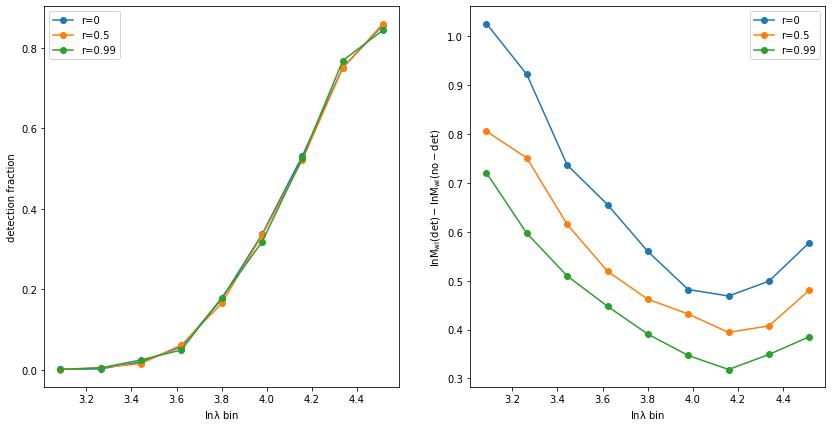

In [20]:
def diff_vs_lambda_bins(r):
    lnlam_bins = np.linspace(np.log(20), np.log(100), 10)
    lnlam_min = lnlam_bins[0:-1]
    lnlam_max = lnlam_bins[1:]
    lnlam_mid = 0.5*(lnlam_min + lnlam_max)
    
    print("The richness bins are:",np.exp(lnlam_bins))
    
    nbins = len(lnlam_min) #lambda bins 
   
    diff_list = np.zeros(nbins)
    det_frac_list = np.zeros(nbins)
    
    for i in range(nbins):
        lnMwl_det, lnMwl_nodet, det_frac = draw_observables(r=r, scatter_wl=0.1, scatter_lam=0.3, scatter_SZ=0.15, 
                     lnlam_min=lnlam_min[i], lnlam_max=lnlam_max[i], lnSZ_cut=np.log(4))
        diff_list[i] = lnMwl_det - lnMwl_nodet
        det_frac_list[i] = det_frac
        

    plt.figure(0, figsize=(14,7))
    plt.subplot(121)
    plt.plot(lnlam_mid, det_frac_list, 'o-', label='r=%g'%r)
    plt.legend()
    plt.xlabel(r'$\rm ln\lambda$ bin')
    plt.ylabel(r'detection fraction')
    #plt.xlim(3, 5.8)
    
    plt.subplot(122)
    plt.plot(lnlam_mid, diff_list, 'o-', label='r=%g'%r)
    plt.legend()
    plt.xlabel(r'$\rm ln\lambda$ bin')
    plt.ylabel(r'$\rm lnM_{wl}(det)- lnM_{wl}(no-det)$')
    #plt.xlim(3, 5.8)

    
    
r_list = [0, 0.5, 0.99]
diff_list = np.zeros(len(r_list))
for i, r in enumerate(r_list):    
    diff_vs_lambda_bins(r)